# Exploratory Data Analysis - Brazilian E-Commerce Public Dataset by Olist


https://www.kaggle.com/olistbr/brazilian-ecommerce


## Table of Contents

1. [Summary of Findings](#summary)
2. [Data Model](#data_model)
3. [Import Libraries](#Import_Libraries)
3. [Load Data](#Load_Data)
4. [Customers Analysis](#customers)
5. [Products Analysis](#products)
6. [Orders and Items Analysis](#orders_items)
7. [Macro Sales Analysis](#macro)
8. [Daily Sales Analysis - Top 10 Product Categories in Sao Paulo](#Top_10)
9. [Target Variable Analysis](#target)


# Summary of Findings <a name = "summary"/>

The raw transactional dataset includes 99441 customer orders. In 2016 there were only 328 orders recorded in the dataset as opposed to 45101 orders in 2017 and 54011 orders in 2018. This suggests that transactions that occured in 2016 may be neglected from analysis & forecasting. Approximately 60% of orders contain only one item in it.

There is a total of 96096 unique customers/users and 93099 customers made only one purchase from Olist. In other words, the dataset has relativley fewer datapoints to examine repeat purchasing behaviour. This suggests that when using a framework for customer value analysis such as the RFM (recency, frequency, monetary) framework, there may be fewer data points to study recency and frequency as opposed to studying the monetary value.

The states of Sao Paulo, Rio de Janeiro and Minas Gerais had the highest number of unique customer orders. Fruther, the bed_bath_table, health_beauty and sports_leisure product categories were the top 3 performers respectively, measured in terms of the number of orders made.

Sales timeseries data contain some trend and seasonality across product categories. The timeseries for average sales in contrast to the absolute value of sales seems to be relatively smoother in terms of volatility. This suggests that the average sales may be relatively easier to predict than the absolute value of sales. Accordingly, sales timeseries used by forecasting models may include the sum and/or the mean of sales per time interval (day, week, month) and accross product categories. 

Looking at daily sales by product category in the state of Sao Paolo, it is observed that only the year of 2017 has data points spanning the entire year. There are many 'zero sales' data points followed by random spikes in sales accross product categories. This makes the task of forecasting more difficult because the size of the training set is not large and patterns are more complex. Both challengs are common in practice.



# Data Model <a name = "data_model"/>

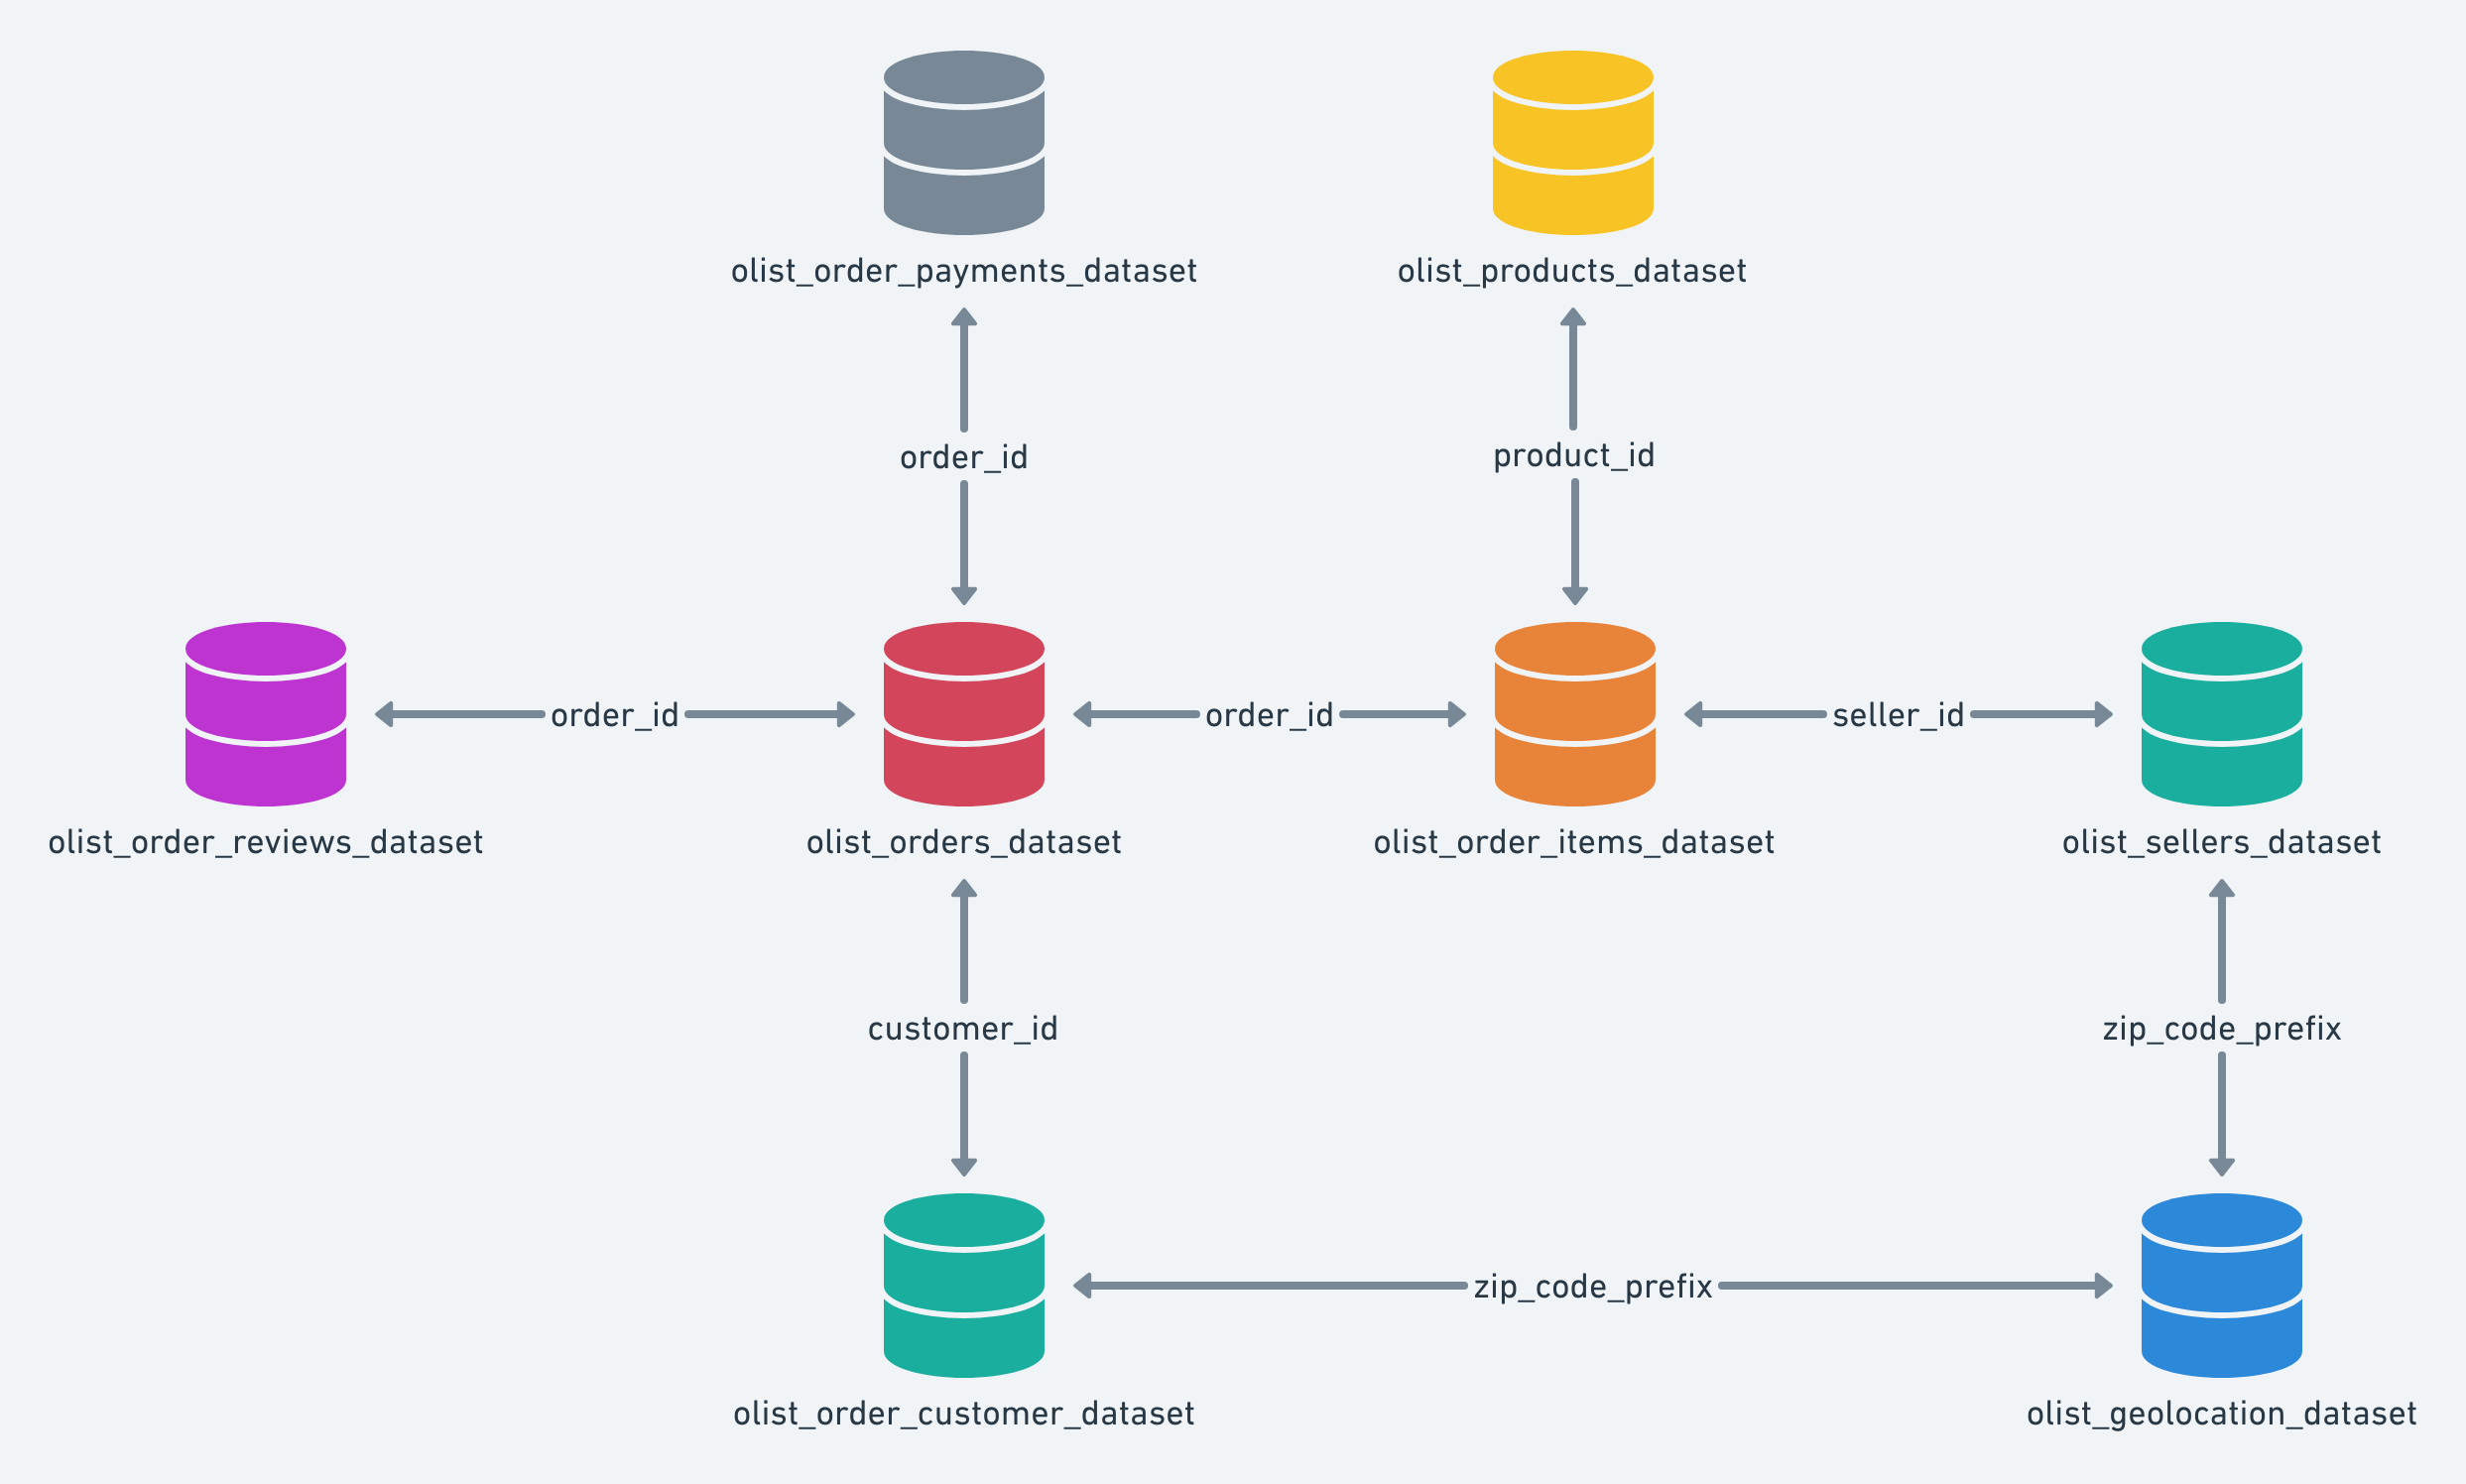

In [1]:
from IPython.display import Image
Image(filename='C:..Data_Model.png') 

# Import Libraries  <a name = "Import_Libraries"/>

In [2]:
import sys
import os
import json
from pprint import pprint
from utils import dataset_2, dataset_2_count
import re
import pandas as pd                        # pandas, the magical dataframe library
import pandas_profiling
import matplotlib.pyplot as plt             # matplotlib.pylot plots data 
plt.style.use('bmh')
import numpy as np                         # numpy provides N-dimensional object support 
import datetime as dt
import seaborn as sns
import math
import matplotlib.mlab as mlab
#conduct data plotting inline instead of in a separate window
%matplotlib inline  

C:\Users\feras\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data <a name = "Load_Data"/>

In [3]:
base_dir = "C:\\..."

# Raw Datasets

customers = pd.read_csv(os.path.join(base_dir,'olist_customers_dataset.csv'))

products = pd.read_csv(os.path.join(base_dir,'olist_products_dataset.csv'))

productcategorynametrans = pd.read_csv(os.path.join(base_dir,'product_category_name_translation.csv'))

orders = pd.read_csv(os.path.join(base_dir,'olist_orders_dataset.csv'))

orderitems = pd.read_csv(os.path.join(base_dir, 'olist_order_items_dataset.csv'))

orderpayments = pd.read_csv(os.path.join(base_dir,'olist_order_payments_dataset.csv'))





# Customers <a name = "customers"/>

This dataset is used to identify unique customers in the orders dataset and to find the order delivery location.

| Attribute Name  | Description | 
| --- | --- | 
| customer_id | Forign key to the orders dataset. A customer ID token that is generated for every order. If the same customer makes multiple orders, he/she will have multiple customer_id identifiers |
| customer_unique_id | Unique ID for a customer. In other words, unique to each purchaser and may be used to track purchases over time|
| customer_zip_code_prefix | First five charachters of the customer address Zip Code |
| customer_state | Name of the customer's state |


In [4]:
pandas_profiling.ProfileReport(customers)

### Unique Customers By State

Text(0, 0.5, 'Count')

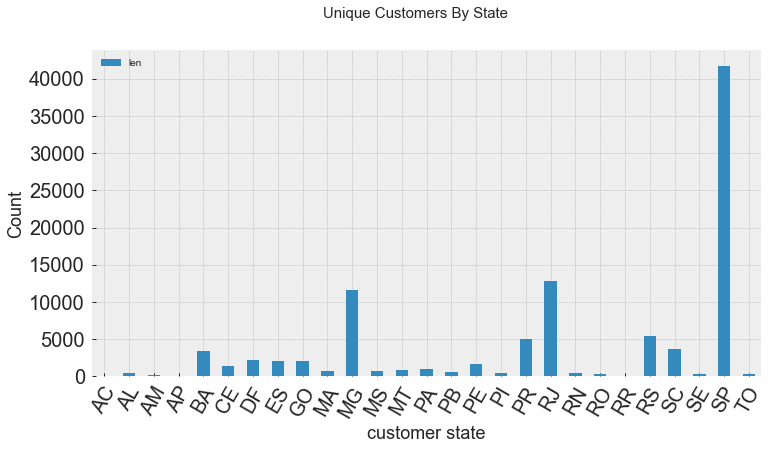

In [5]:
#Count frequency of unique customers per state 

customer_by_state = customers.groupby(['customer_state']).customer_unique_id.agg([len])
#display(customer_by_state.sort_values( by='len', ascending=False))

#plot the number of unique customers per state 

customer_by_state.plot.bar(fontsize=20,rot=60,figsize=(12,6))

plt.suptitle('Unique Customers By State', fontsize=15)

plt.xlabel('customer state', fontsize=18)

plt.ylabel('Count', fontsize=18)

### Number of Purchases Made by Customers

In [6]:
print("The goal is to identify repeat purchasing habits for customers by counting the frequency of purchases over time.")

display ("As seen below, majority of purchases are on a 1-time basis")
customers.groupby('customer_unique_id').size().value_counts()


The goal is to identify repeat purchasing habits for customers by counting the frequency of purchases over time.


'As seen below, majority of purchases are on a 1-time basis'

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

# Products <a name = "products"/>


| Attribute Name  | Description | 
| --- | --- | 
| product_id | unique product identifier |
| product_category_name | Product category name in Portuguese|
| product_name_lenght | Number of characters in the product's name |
| product_description_lenght | Number of characters used to describe a product |
| product_photos_qty | Number of photos available for the product |
| product_weight_g | Weight of a product in grams |
| product_length_cm | Length dimension of a product in CM |
| product_height_cm | Height dimension of a product in CM |
| product_width_cm | Width dimension of a product in CM |

In [7]:
#Store translations in a dictionary 
productcategorynametrans = productcategorynametrans.set_index('product_category_name')['product_category_name_english'].to_dict()


# translate the product category column in the products table to English
products['product_category_name'] = products['product_category_name'].map(productcategorynametrans)

#products.head(5)


In [8]:
pandas_profiling.ProfileReport(products)

### Top 10 Distribution of Unique Products per Category

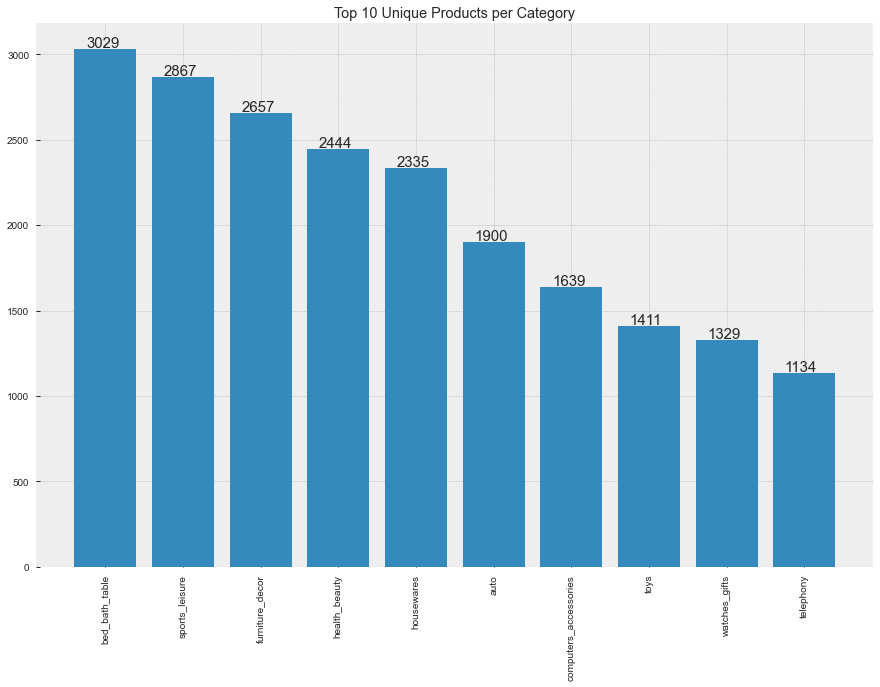

In [9]:
#display("numner of unique products = " + str(len(products['product_id'])))
#display("number of unique categories = " + str(len(products['product_category_name'].unique())))

# Top 10 distribution of unique products per category

product_category = products[['product_id','product_category_name']] \
.groupby('product_category_name')['product_id'] \
.count()\
.sort_values(ascending=False) \
.to_dict()

product_category_names = list(product_category.keys())[:10]
product_category_values = list(product_category.values())[:10]

# fucntion to plot values in dictionary 

def plot_bar_graph(x,y,title):
    fig, axs = plt.subplots(1, 1, figsize=(15, 10), sharey=True)
    axs.bar(x, y)
    axs.set_title(title)
    plt.xticks(rotation =90)

    # data labels
    for i, v in enumerate(y):
        axs.text(i-.25, 
                  v+10, 
                  y[i], 
                  fontsize=15, 
                 
                )
    return plt.show()

plot_bar_graph(product_category_names,product_category_values,"Top 10 Unique Products per Category")

### Product Categories With the Highest Demand

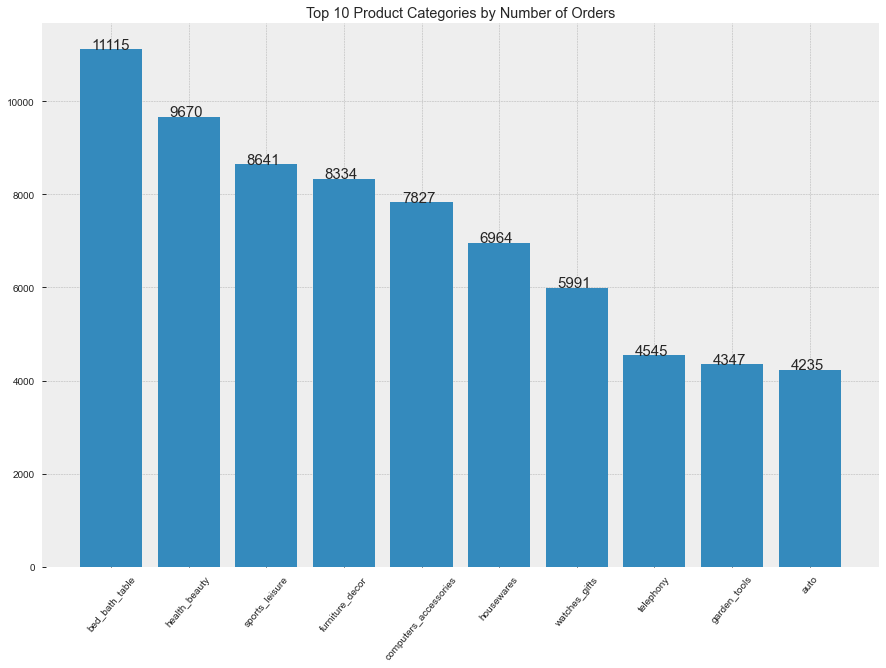

In [10]:
# Top 10 Product Categories Made on Orders

# Join the oreders and products tables 
order_products = pd.merge(orderitems, products, left_on = 'product_id', right_on = 'product_id')

# drop the orders with missing category names
order_products = order_products.dropna(subset=["product_category_name","order_id"])

# plot the data
order_products[['product_category_name','order_id']]

order_products_dict = order_products[['product_category_name','order_id']] \
.groupby('product_category_name')['order_id'] \
.count()\
.sort_values(ascending=False) \
.to_dict()


order_product_names = list(order_products_dict.keys())[:10]
order_product_values = list(order_products_dict.values())[:10]

# fucntion to plot values in dictionary 

def plot_bar_graph(x,y,title):
    fig, axs = plt.subplots(1, 1, figsize=(15, 10), sharey=True)
    axs.bar(x,y)
    axs.set_title(title)
    plt.xticks(rotation =50)
    

    # data labels
    for i, v in enumerate(y):
        axs.text(i-.25, 
                  v+10, 
                  y[i], 
                  fontsize=15, 
                 
                )
    return plt.show()

plot_bar_graph(order_product_names,order_product_values,"Top 10 Product Categories by Number of Orders")

# Orders and Items <a name = "orders_items"/>
### Orders Dataset

This is the primary dataset that links the majority of tables together. 

| Attribute Name  | Description | 
| --- | --- | 
| order_id | Unique identifier of the order. An order might have multiple items each item might be fulfilled by a distinct seller |
| customer_id | Key to the customer dataset. Each order has a unique customer_id|
| order_status | Status of the order. Ex: delivered, shipped|
| order_purchase_timestamp | Timestamp for the purchase transaction i.e. when the purchase was  made|
| order_approved_at | Timestamp for the payment approval|
| order_delivered_carrier_date | Timestamp for when the order was handed to the logistic partner/3PL|
| order_delivered_customer_date | Actual date that the merchendise was delievered to the customer|
| order_estimated_delivery_date | Estimated initial delivery date that was communicated to the customer at the purchase moment|

### Order Items Dataset

| Attribute Name  | Description | 
| --- | --- | 
| order_id | Unique identifier of the order. An order might have multiple items each item might be fulfilled by a distinct seller |
| order_item_id | Represnts the quanitty of items included in the same order.|
| product_ID | Unique identififer for the product on the order|
| seller_ID| Unique identififer of the seller for a given order. Each item on an order might be fulfilled by a distinct seller.|
| shipping_limit_date| Shows the seller shipping limit date for handling the order over to the logistic partner|
| price_item| the price for an order item |
| freight_value | Item freight value (if an order has more than one item the freight value is splitted between items |

In [11]:
pandas_profiling.ProfileReport(orders)

In [12]:
pandas_profiling.ProfileReport(orderitems)

### Annual Order Volumes

2018    54011
2017    45101
2016      329
Name: year, dtype: int64

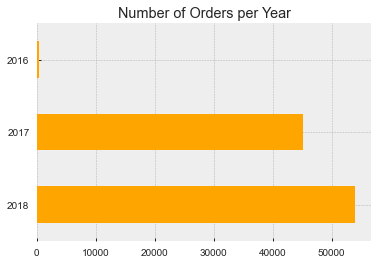

In [13]:
orders["year"]= orders['order_purchase_timestamp'].str[:4]

results=orders["year"].value_counts()

ax=results.plot(kind="barh", color = 'orange' , title="Number of Orders per Year", rot=0)

display(results)

### Count Orders By Status

Text(0.5, 1.0, 'Number of Orders Per Status')

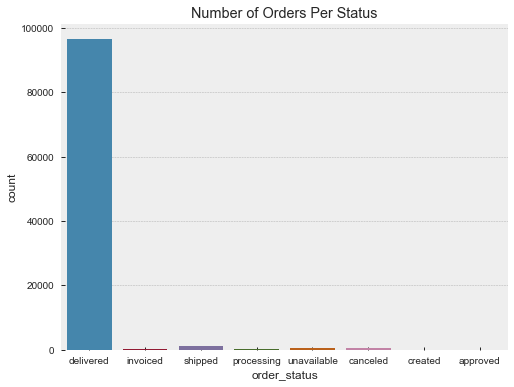

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(orders['order_status'])
plt.title('Number of Orders Per Status')

### Count Number of Orders Containing Multiple Items

'Total Orders: 98666'

'Total Orders with 2 or more items: 13984'

Text(0, 0.5, 'Percentage of total orders')

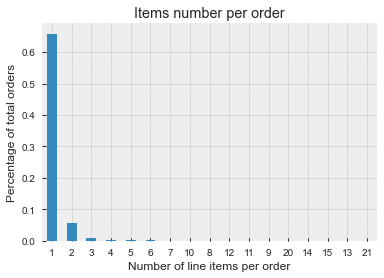

In [15]:
# Count number of orders with more than one line item
display("Total Orders: " + str(len(orderitems['order_id'].unique())))
display("Total Orders with 2 or more items: " + str(len(orderitems[orderitems['order_item_id'] >= 2])))


# Visualize the number of line items found for all orders and express in percentage
ax=pd.DataFrame(orderitems.groupby(by='order_id')['order_item_id'].size().value_counts()).apply(lambda x:x/orderitems['order_item_id'].sum()).plot(kind="bar", title="Items number per order", rot=0)
ax.legend("")
ax.set_xlabel("Number of line items per order")
ax.set_ylabel("Percentage of total orders")

# Macro Sales Analysis <a name = "macro"/>

## Annual Trend and Distrubution of Sales Over Time

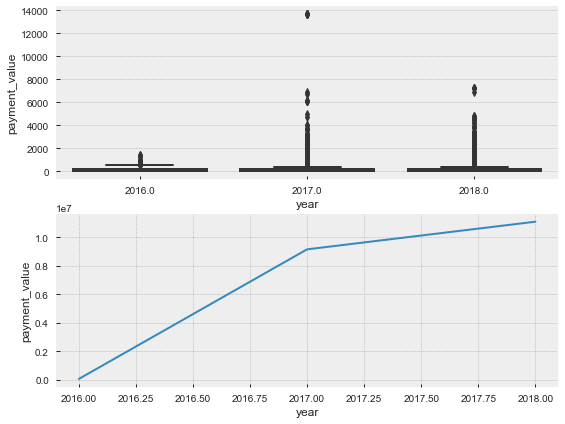

In [16]:
# Join the orders with customers table then join the orders_customers table with order items

sales_order = pd.merge(orders,customers,on='customer_id',how='inner')

# Merge the sales_order table with the orderitems table

sales_order_item = orderitems.merge(sales_order, on = 'order_id', how = 'left')
                         
# Merge product information with the sales_order_item table

sales_order_full = sales_order_item.merge(products,on = 'product_id',how = 'inner')

#Extract year, month and week stamps from the transaction time-stamp. 
#We focus only on transactions for which we have a confirmed payment represented by the field |order_approved_at|

sales_order_full['order_approved_at'] = pd.to_datetime(sales_order_full['order_approved_at'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features 
sales_order_full['year'] = sales_order_full['order_approved_at'].dt.year

sales_order_full['month'] = sales_order_full['order_approved_at'].dt.month

sales_order_full['week'] = sales_order_full['order_approved_at'].dt.week

sales_order_full['day'] = sales_order_full['order_approved_at'].dt.day

sales_order_full['weekday'] = sales_order_full['order_approved_at'].dt.weekday

sales_order_full['weekday'] = np.where(sales_order_full.weekday == 0, 7, sales_order_full.weekday)

#merge sales orders with payments
sales_order_with_payments = sales_order_full.merge(orderpayments, on='order_id')

#Plot 
yearly_agg = sales_order_with_payments.groupby('year')['payment_value'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='year', y='payment_value', data=yearly_agg, ax=axs[1])

## Annual Average Sales Over Time

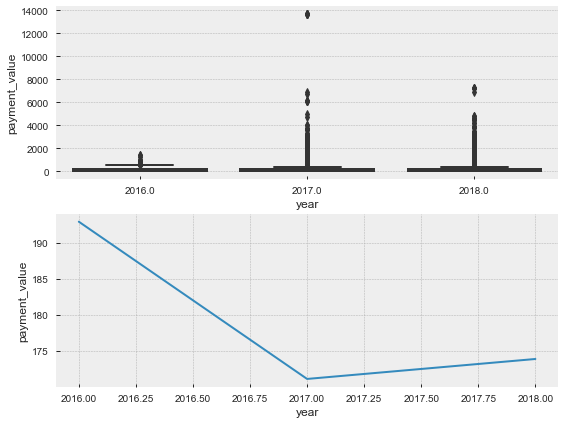

In [17]:
yearly_agg = sales_order_with_payments.groupby('year')['payment_value'].mean().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='year', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='year', y='payment_value', data=yearly_agg, ax=axs[1])

Sales have icnreased year over year. In 2017 there are occurances of sales that are of high-value and could be considered as outliers. 

Annual average sales have decreased consistently in 2016. Average sales have consistently increased from 2017 - 2018

Having more historical annual sales data would help to extract additional information

## Monthly Trend and Distrubution of Sales Over Time

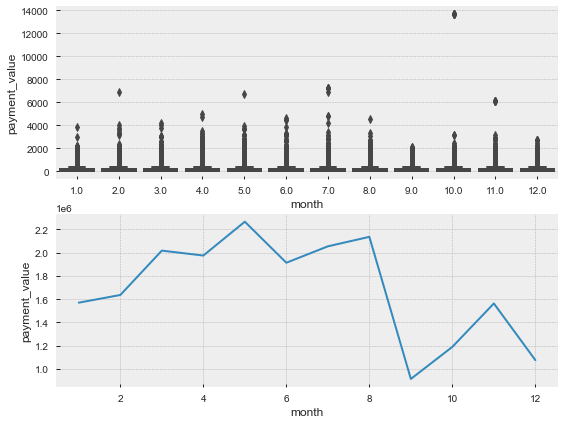

In [18]:
monthly_agg = sales_order_with_payments.groupby('month')['payment_value'].sum().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(9,7))

sns.boxplot(x='month', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='month', y='payment_value', data=monthly_agg, ax=axs[1])


## Monthly Average Sales Over Time


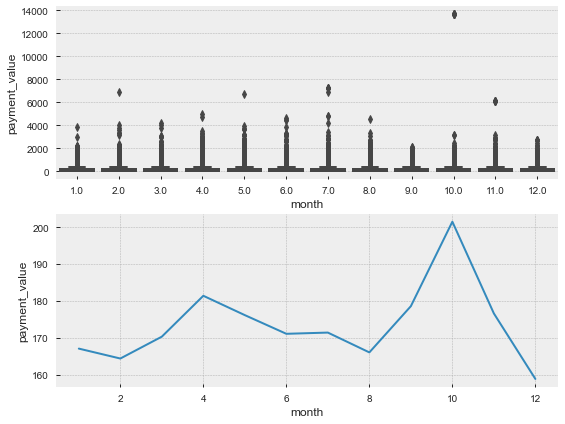

In [19]:
monthly_agg = sales_order_with_payments.groupby('month')['payment_value'].mean().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(9,7))

sns.boxplot(x='month', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='month', y='payment_value', data=monthly_agg, ax=axs[1])


The amount of sales increases month over month with peaks in May and August. After August sales decrease sharply until September. There is a sharp increase in  sales from September until November. Sales then fall in December. Sales over months are volatile.

When looking at the average monthly sales distrubution over time, we see a more smooth trend with two peaks that correspond to April & Octobor.


### Weekly Trend and Distribution of Sales Over Time

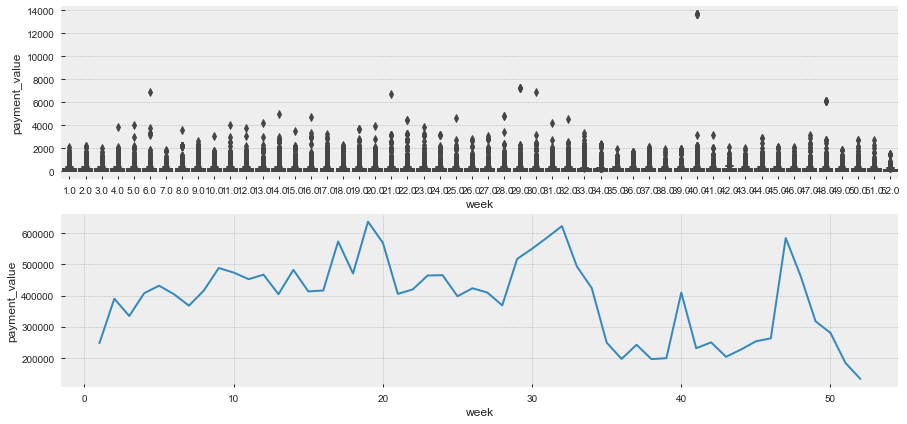

In [20]:
weekly_agg = sales_order_with_payments.groupby('week')['payment_value'].sum().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(15,7))

sns.boxplot(x='week', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='week', y='payment_value', data=weekly_agg, ax=axs[1])


### Average Weekly Sales Over Time

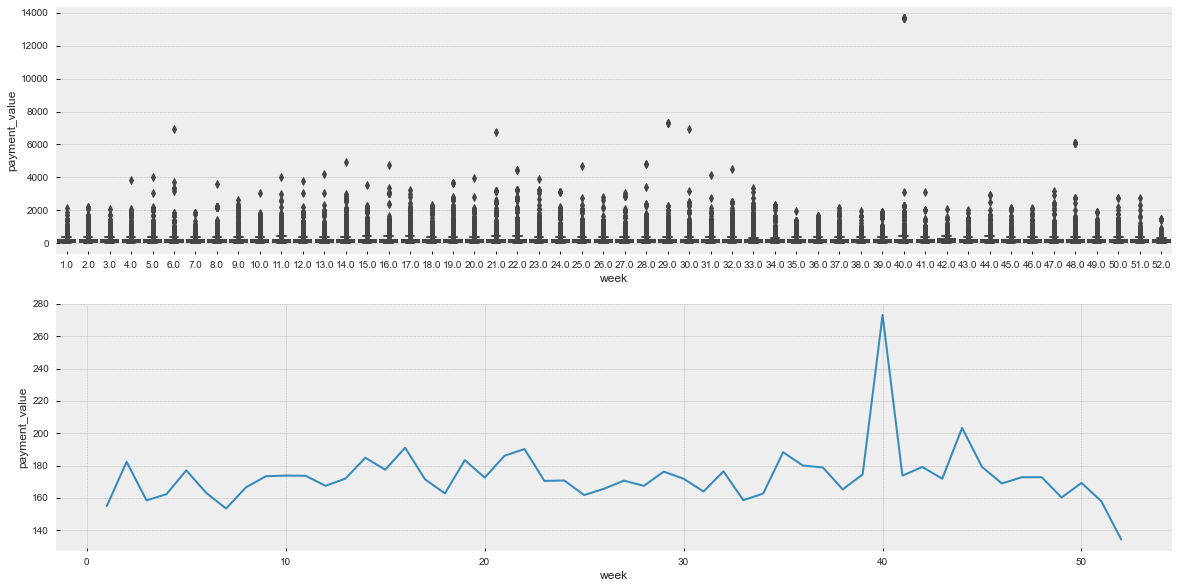

In [21]:
weekly_agg = sales_order_with_payments.groupby('week')['payment_value'].mean().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(20,10))

sns.boxplot(x='week', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='week', y='payment_value', data=weekly_agg, ax=axs[1])


### Weekday Trend and Distrubution of Sales Over Time

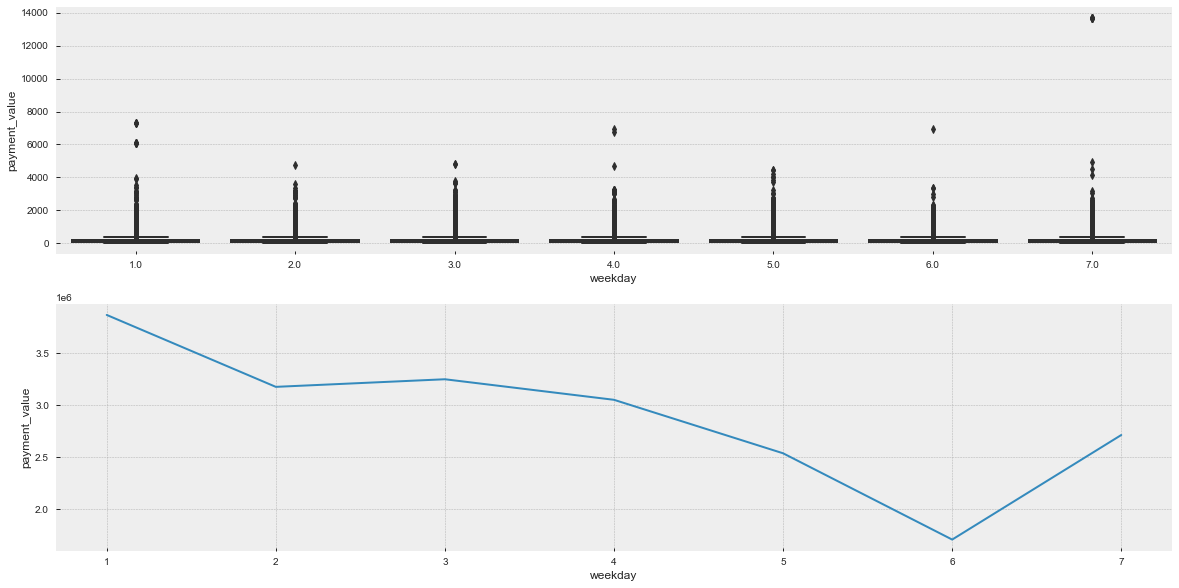

In [22]:
weekly_agg = sales_order_with_payments.groupby('weekday')['payment_value'].sum().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(20,10))

sns.boxplot(x='weekday', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='weekday', y='payment_value', data=weekly_agg, ax=axs[1])


### Average Weekday Sales Over Time

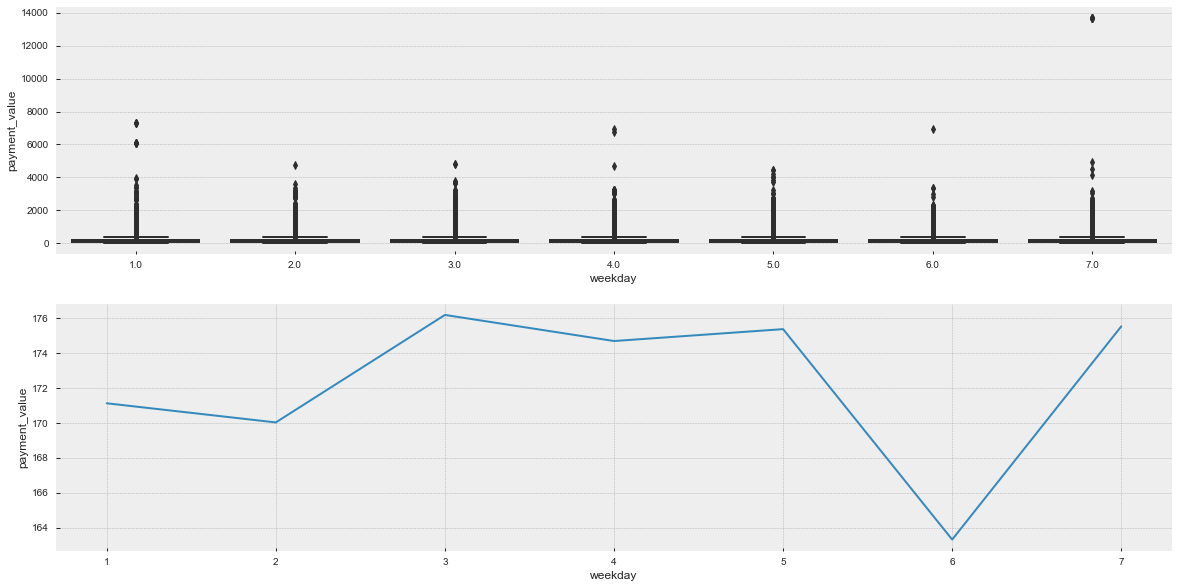

In [23]:
weekly_agg = sales_order_with_payments.groupby('weekday')['payment_value'].mean().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(20,10))

sns.boxplot(x='weekday', y='payment_value', data=sales_order_with_payments, ax=axs[0])
_ = sns.lineplot(x='weekday', y='payment_value', data=weekly_agg, ax=axs[1])


Weekly sales are volatile over time in comparison to a smoother curve seen when average sales over the weeks are observed.

Highest sales tend to occur on Mondays and the lowest sales seem to be on Saturdays. 

Average sales increase from Teusday to Wednesday. Average sales slightly decrease from Wednesday to Thursday and pick up again on Friday. On Saturday's average sales sharply decrease and gain momentum back on Sunday. 

# Daily Sales Analysis - Top 10 Product Categories in Sao Paulo <a name = "Top_10"/>

In [24]:
# Read Config file
config = "configs_EDA.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2018-12-01',
           'test_start': '2018-07-01',
           'train_start': '2016-11-15',
           'valid_start': '2018-06-01'},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': False,
 'end_date': '2018-12-31 23:59:59',
 'pre_processing': {'add_date_features': True,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'r_list': [0],
                    'rolling_history': False,
                    'window_size': 7},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm_product_category': False,
 'start_d

In [25]:
train_df_c,valid_df_c,test_df_c = dataset_2_count.make_dataset(config)
train_df,valid_df,test_df = dataset_2.make_dataset(config)

## Sample Training Period

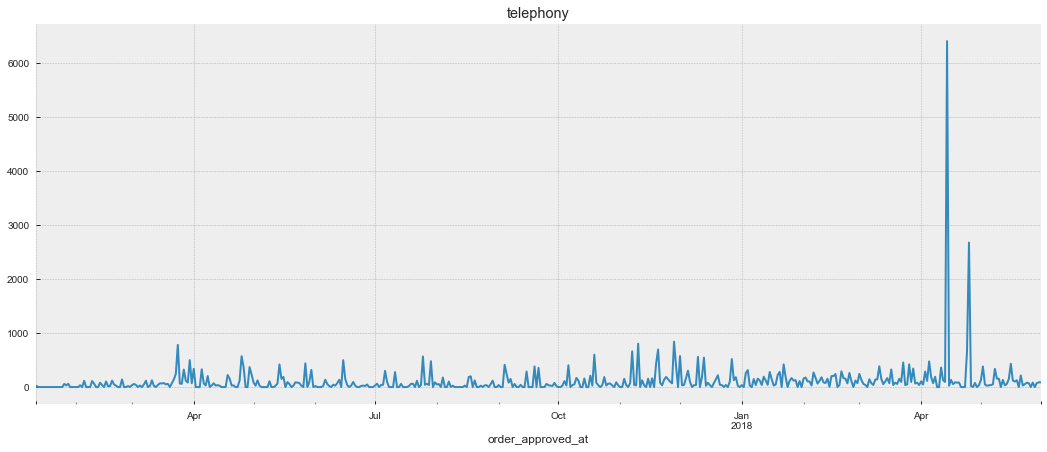

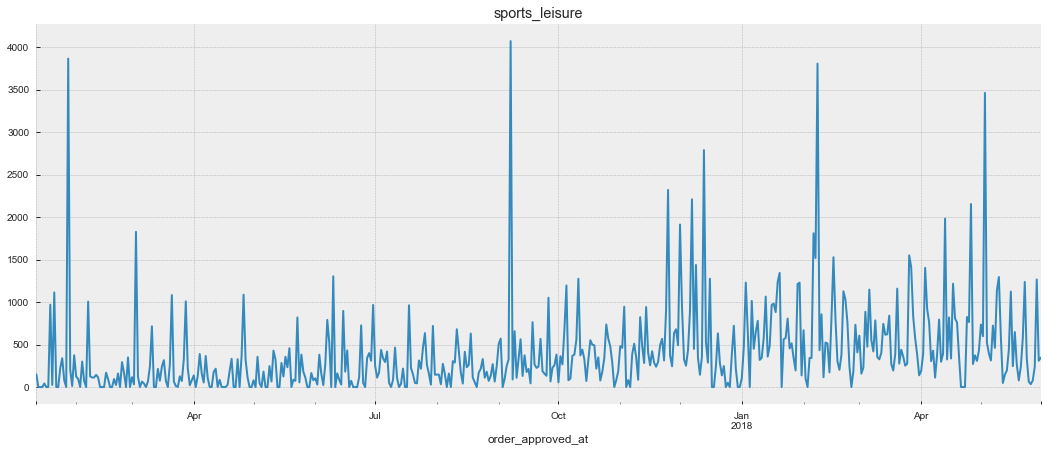

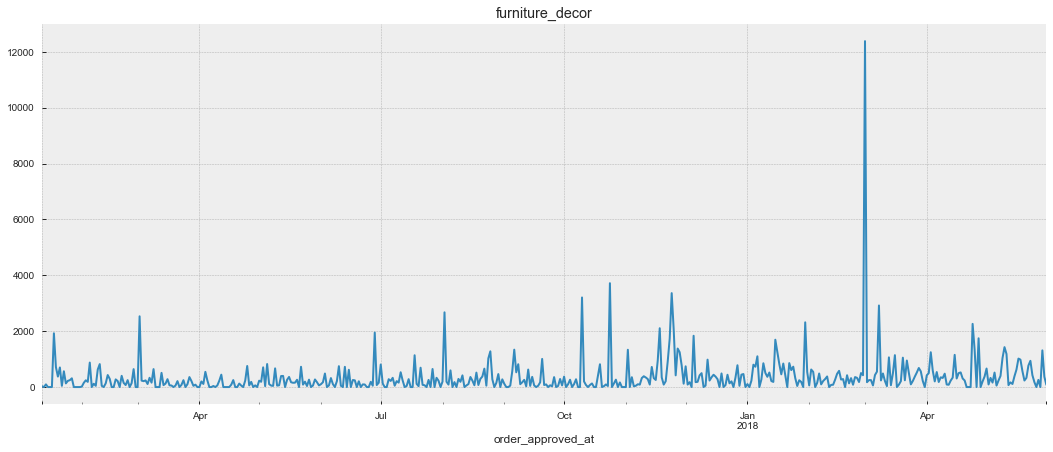

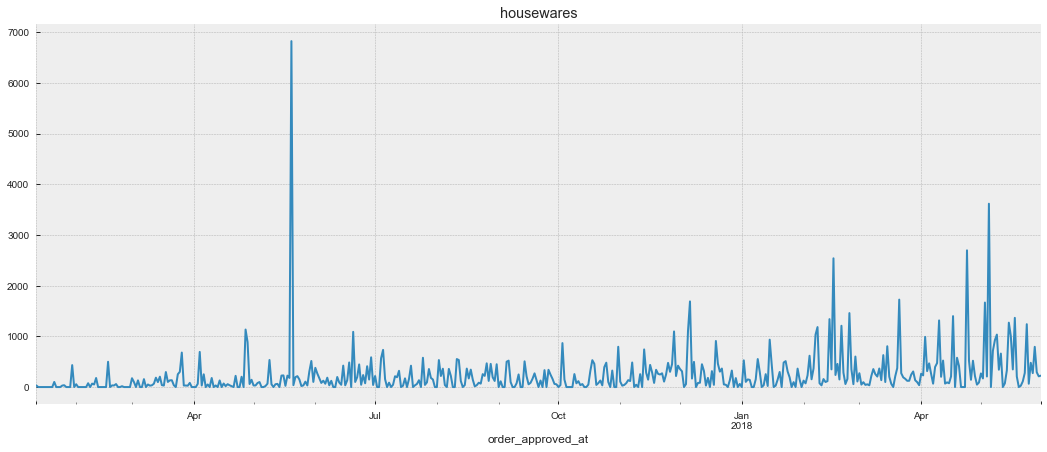

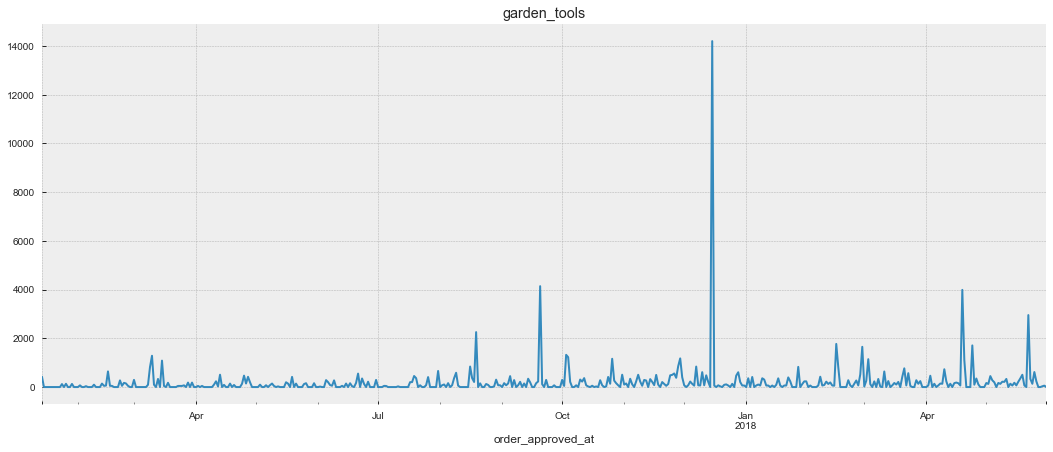

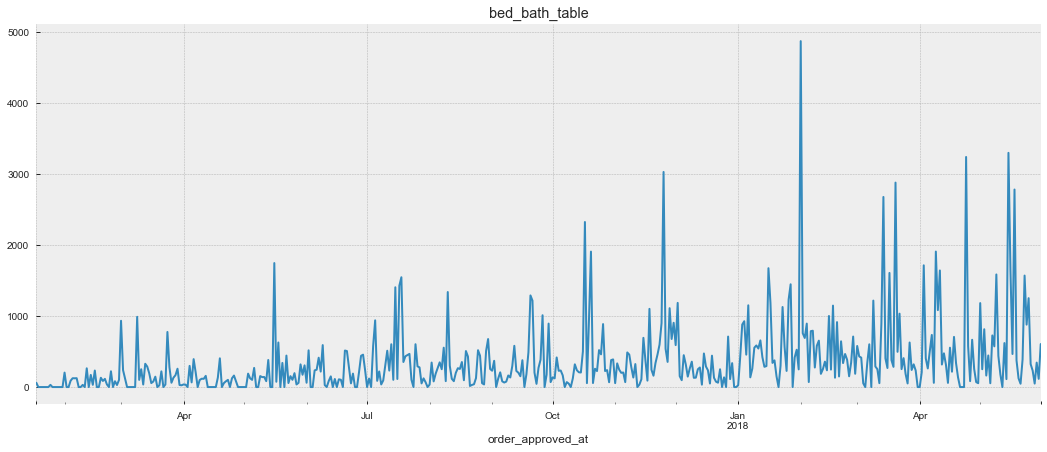

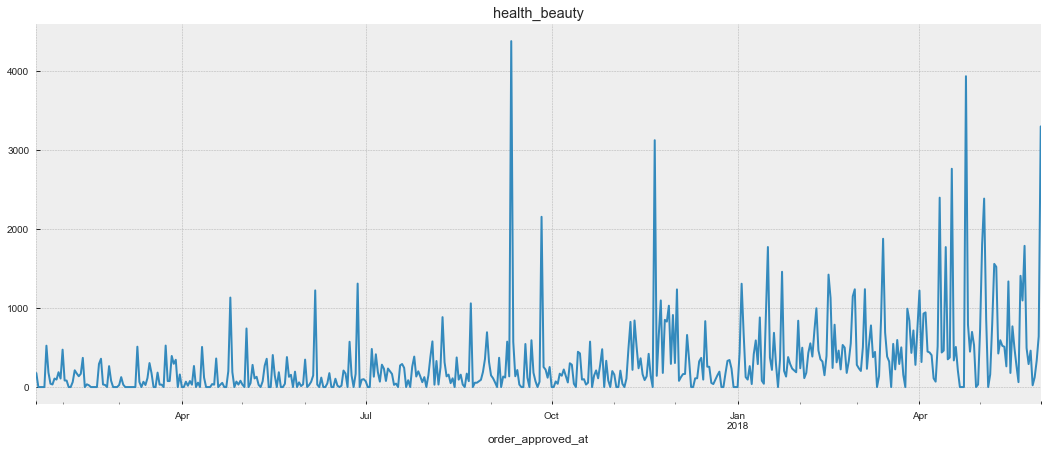

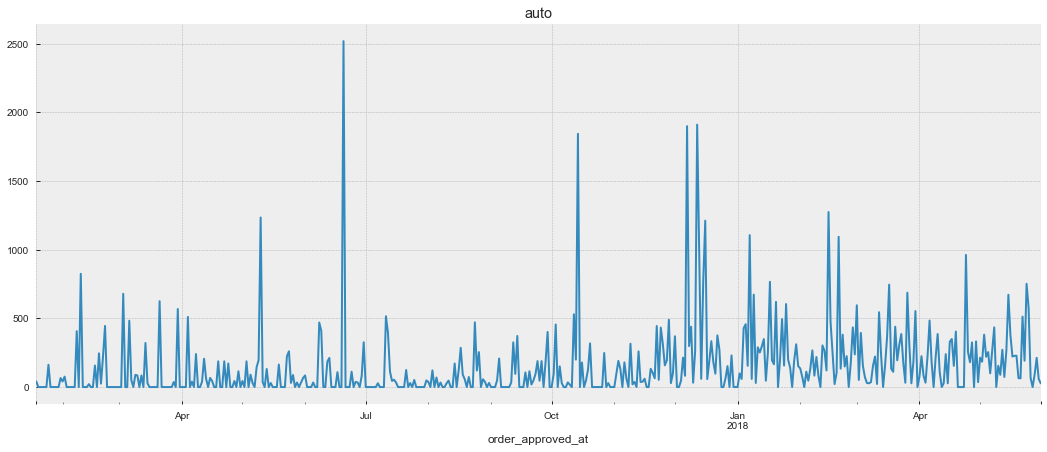

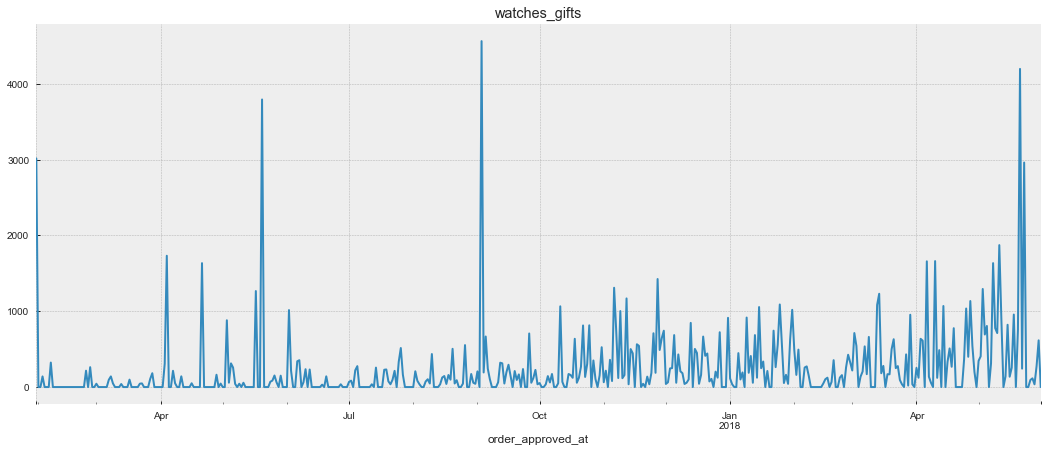

In [26]:
# Look into a sample training period
for pc in train_df.product_category_name.unique():
    train_product = train_df[train_df['product_category_name']==pc]['payment_value']
    train_product.index = train_df[train_df['product_category_name']==pc]['order_approved_at']
    train_product.plot(figsize=(18,7))
    plt.title(pc)
    plt.show()

## Sample Validation Set - Transaction Count & Amount

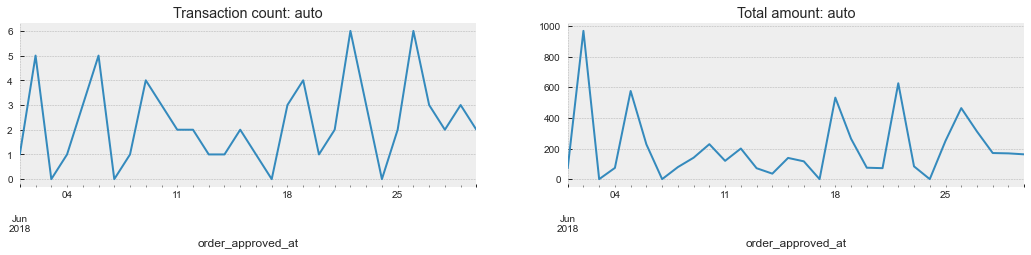

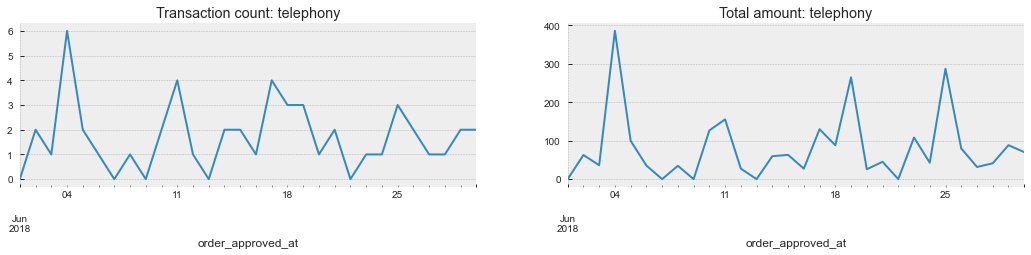

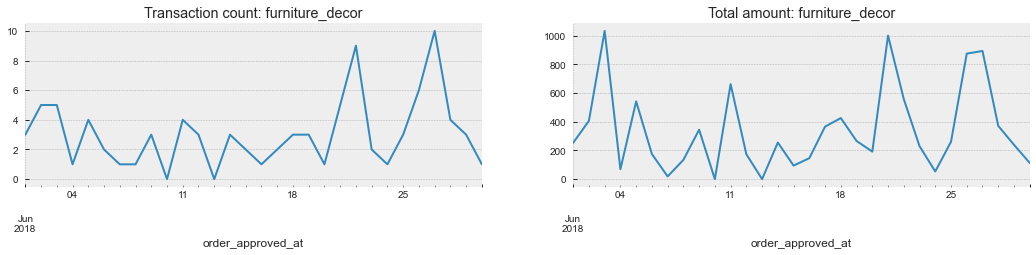

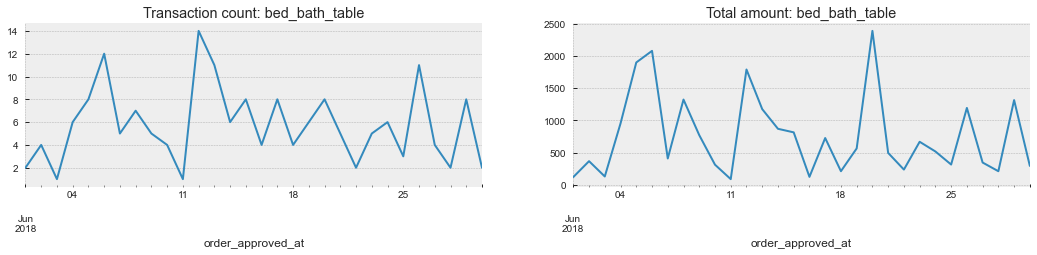

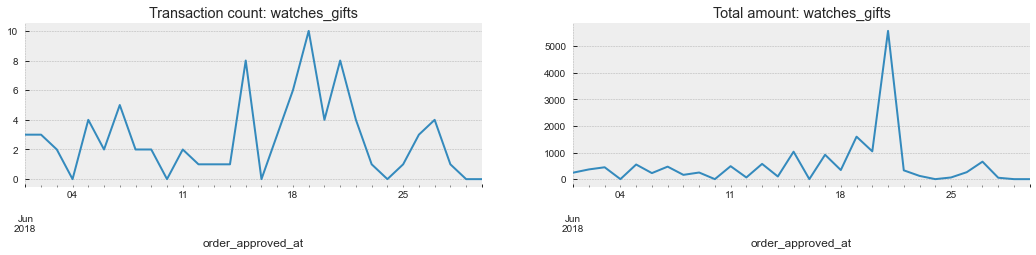

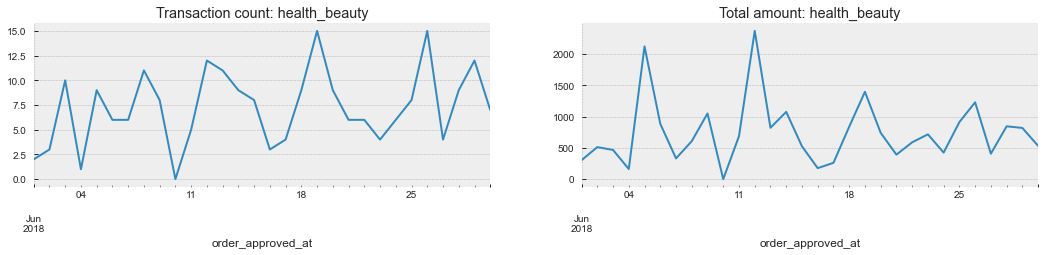

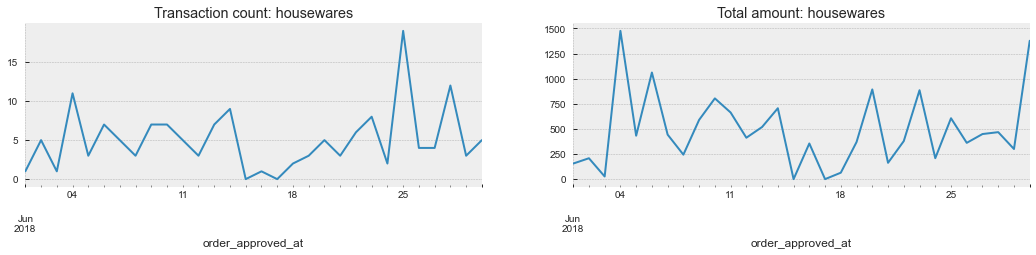

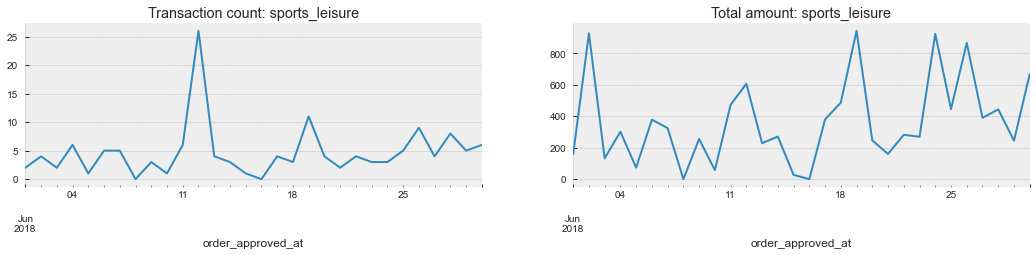

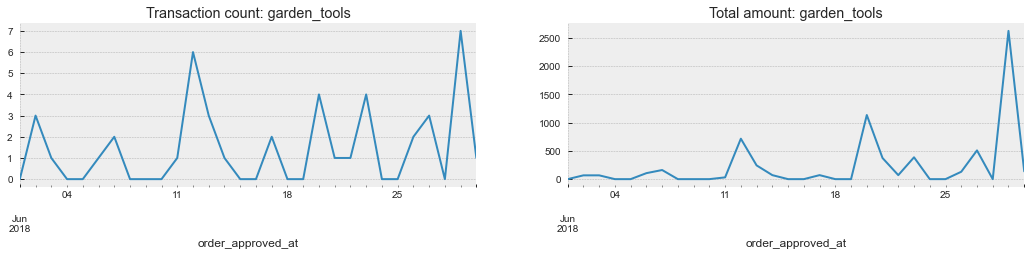

In [27]:
valid_df_c.set_index('order_approved_at',inplace=True)
valid_df.set_index('order_approved_at',inplace=True)
for prod_cat in valid_df.product_category_name.unique():
    valid_df_c_product = valid_df_c.loc[valid_df_c['product_category_name'] == prod_cat].copy()
    valid_df_product = valid_df.loc[valid_df['product_category_name'] == prod_cat].copy()
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(18,3))
    valid_df_c_product['payment_value'].plot(ax=axes[0],title=f'Transaction count: {prod_cat}')
    valid_df_product['payment_value'].plot(ax=axes[1],title=f'Total amount: {prod_cat}')
    plt.show()

## Sample Testing Period

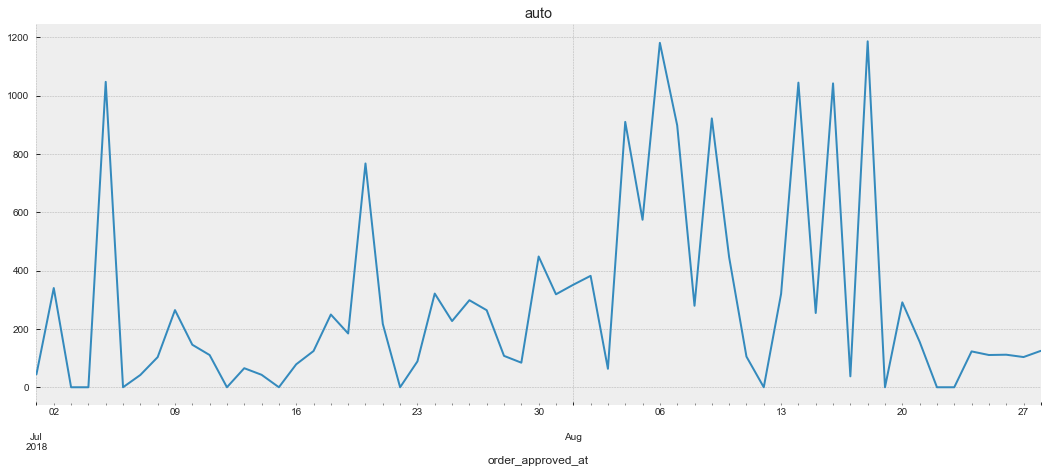

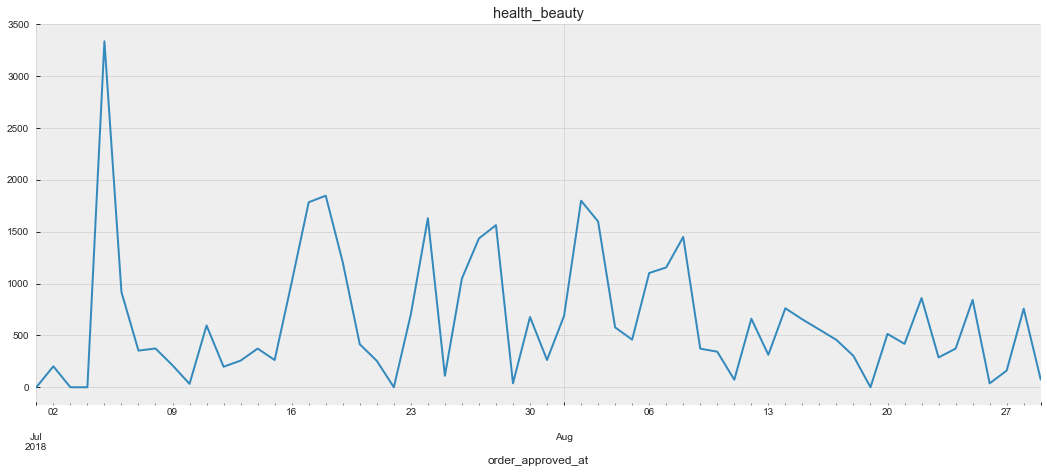

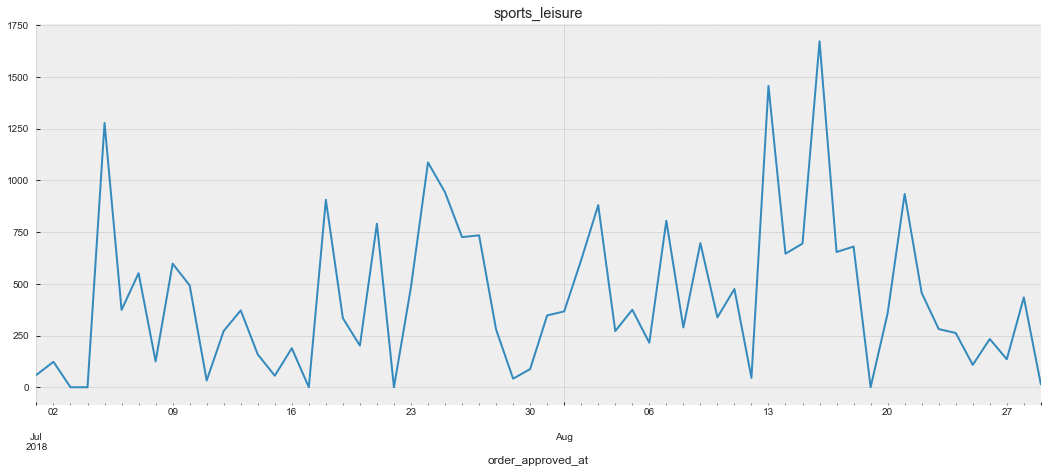

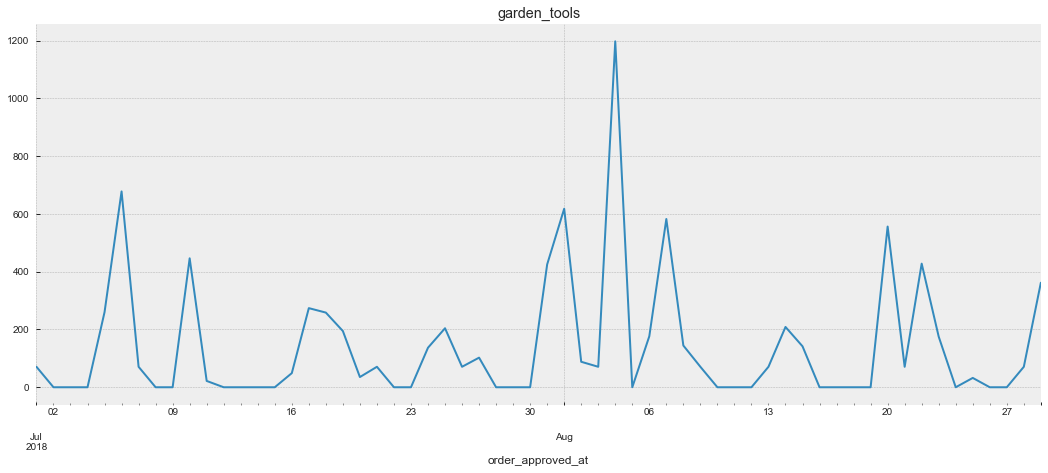

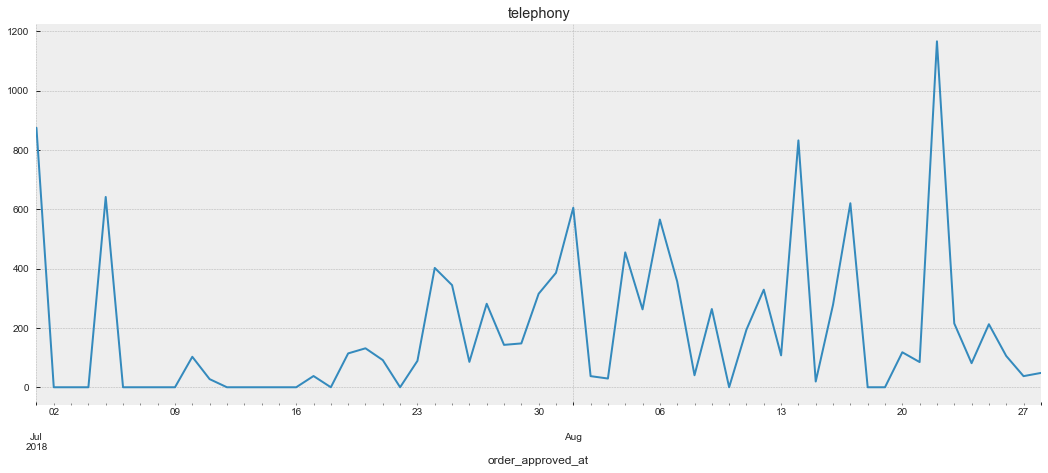

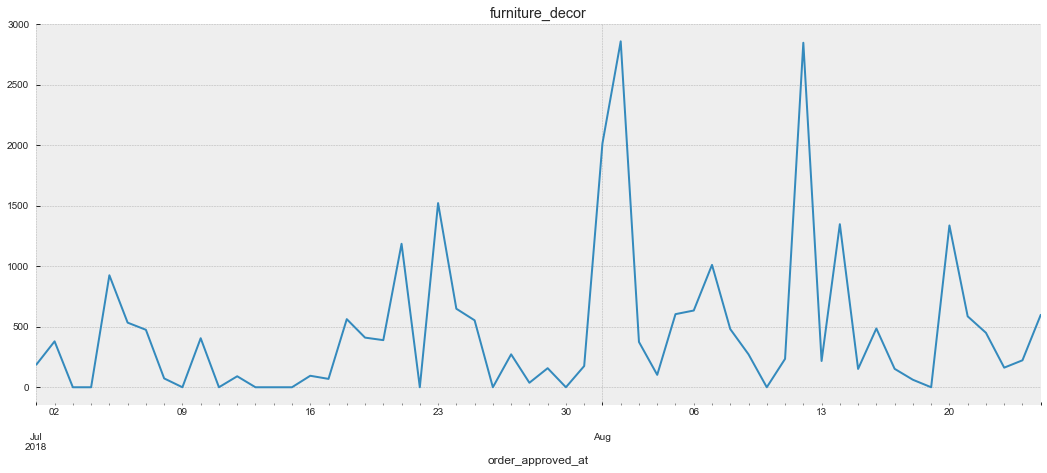

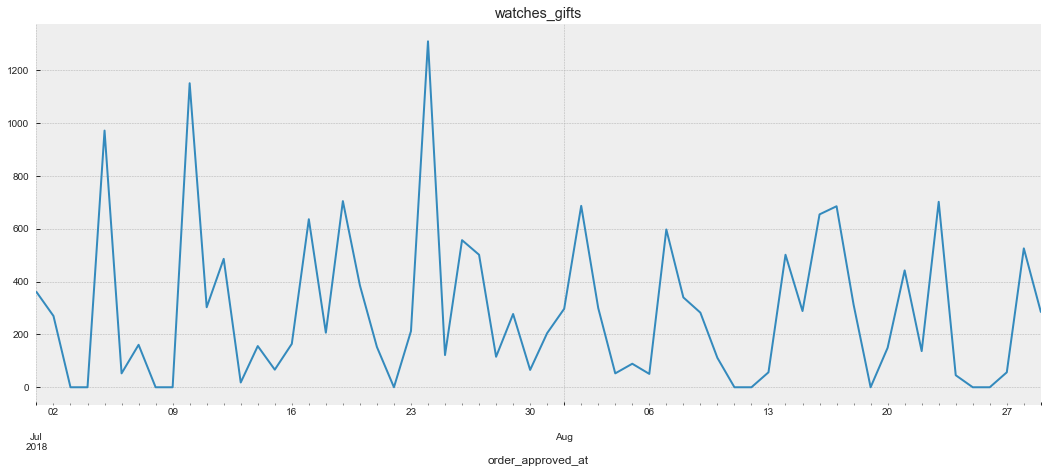

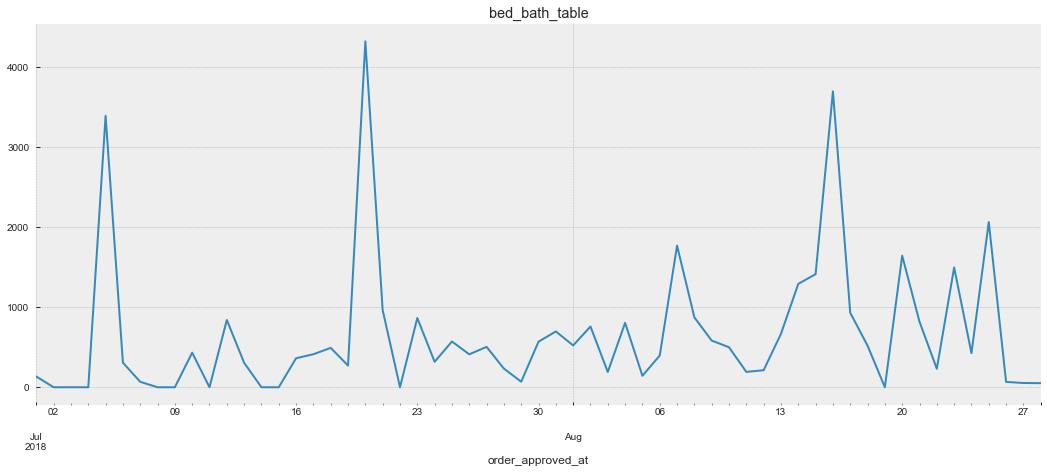

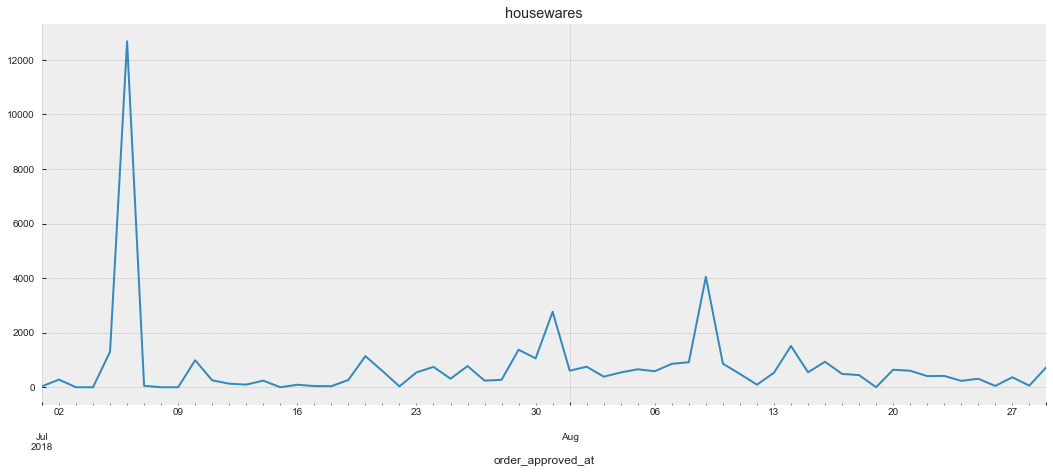

In [28]:
# Look into a sample testing period
for pc in test_df.product_category_name.unique():
    test_product = test_df[test_df['product_category_name']==pc]['payment_value']
    test_product.index = test_df[test_df['product_category_name']==pc]['order_approved_at']
    test_product.plot(figsize=(18,7))
    plt.title(pc)
    plt.show()

# Distribution of the Target Variable <a name = "target"/>

Based on the number of variables, the probability distribution of output variables and form of relationship (linear versus nonlinear), different types of regression models are available for use.

Single and multi linear regression models stipulate that the dependent variable is a real value and assumed to follow a normal distribution. 

The target variable payment_value has a left-skewed distribution. Taking the log transformation of the target variable would result in having the target variable normally distributed. A normally distributed target variable helps in better modeling the relationship between target and independent variables. In addition, linear algorithms assume constant variance in the error term.

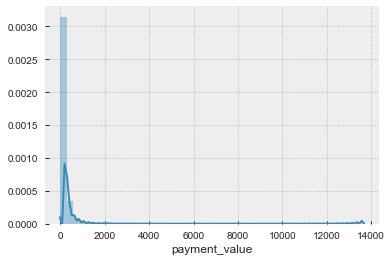

In [29]:
#Plot the distrubation of target variable which is sales (payment_value)
sns.distplot(sales_order_with_payments['payment_value'])


In [30]:
#skewness
sales_order_with_payments['payment_value'].skew()

14.089988964625634